# ДЗ2. Мультимодальный адаптер к Qwen3-0.6B

**Описание задания**

В этом задании вы подключите внешнюю модальность (аудио или изображение) к языковой модели Qwen3-0.6B через небольшой обучаемый адаптер. Веса Qwen и выбранного предобученного энкодера мы замораживаем, обучается только адаптер.

Выберите один из треков:

- Трек A (аудио → текст)

Описываем аудио (AudioCaps) с помощью Qwen. Энкодер: `HuBERT` / `wav2vec2` / `Whisper Encoder`.

- Трек B (изображение → текст)

Описываем изображения (image captioning датасет) с помощью Qwen. Энкодер: любая vision-модель.

**Задачи:**

1.   Заморозить параметры `QWEN` и предобученного энкодера (аудио или vision).

2.   Создать и обучить адаптер, который сжимает временную / пространственную размерность признаков и проецирует их в скрытое пространство `Qwen`.

3.   Подготовить данные для обучения и валидации модели.

4.   Реализовать и сравнить несколько стратегий пулинга в адаптере (например, сжатие временной размерности для аудио или пространственной - для изображений).

5.   Использовать `BERTScore` для оценки качества модели на отложенном датасете.

**Основные этапы задания**

*   Подготовка данных: для "аудио → текст" загрузите датасет AudioCaps, если "изображение → текст", то загрузите датасет для image captioning (например, `Flickr8k`), обработайте данные и создайте DataLoader для батчевого обучения. Рекомендуется выполнить полную предобработку данных (прекомпьют), чтобы сократить время обработки на этапе обучения.
*   Реализация адаптера: создайте класс, который сжимает последовательность векторов.
*   Интеграция с `QWEN`: реализуйте обработку входов и передачу через `QWEN`.
*   Обучение модели: настройте процесс обучения с использованием `Cross Entropy Loss` и teacher forcing.
*   Оценка: вычислите BERTScore между сгенерированными и реальными текстами на валидационном датасете.

> **Внимание!** Последующие ячейки с условиями оформлены (название классов и переменных, инструкциии и комментарии) в ключе работы по треку А (аудио → текст). Если вы выбираете работать с vision задачей, можете ориентироваться содержательно на представленные кодовые сниппеты, но видоизменять их под свою задачу.

### Сеттинг

In [1]:
# !pip install transformers
# !pip install datasets torchaudio
# !pip install bert_score

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
    Wav2Vec2Processor,
    Wav2Vec2Model,
)
from datasets import load_dataset
import random
import numpy as np
import pandas as pd
from bert_score import BERTScorer
from tqdm import tqdm

import soundfile as sf  # для загрузки .flac файлов

from pathlib import Path  # для современной работы с путями
import json

# для красивого вывода
import rich
from rich.pretty import pprint as pprint

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


**Загрузка данных**

Если вы выбираете трек с аудио, используйте датасет `AudioCaps`.

In [4]:
# your code here
# (╯°□°）╯︵ ┻━┻
# Уже загружен из ДЗ1
# !kaggle datasets download nickkar30/audiocaps

DATA_ROOT = Path("./audiocaps/audiocaps")
pprint(list(DATA_ROOT.iterdir()))


[
│   PosixPath('audiocaps/audiocaps/audiocaps_test_new.tsv'),
│   PosixPath('audiocaps/audiocaps/val_texts.json'),
│   PosixPath('audiocaps/audiocaps/test_texts.json'),
│   PosixPath('audiocaps/audiocaps/audiocaps_train.tsv'),
│   PosixPath('audiocaps/audiocaps/audio'),
│   PosixPath('audiocaps/audiocaps/audiocaps_train_fixed.tsv'),
│   PosixPath('audiocaps/audiocaps/audiocaps_test.tsv'),
│   PosixPath('audiocaps/audiocaps/audiocaps_val_new.tsv'),
│   PosixPath('audiocaps/audiocaps/audiocaps_val.tsv')
]

### Задание 1. Создание и обучение AudioConvAdapter (3 балла)

1. Загрузите модель **Qwen3-0.6B** и заморозьте её параметры.  
2. Загрузите предобученный аудио-энкодер (параметры также должны быть заморожены). Вы можете выбрать одну из следующих моделей: **HuBERT**, **wav2vec2**, или **Whisper Encoder**. Учтите особенности выбранной модели:  
   - Например, `wav2vec2-large-960h-lv60-self` использует `flash_attention`, которая работает только с GPU архитектуры Ampere и с типом данных float16. Это может вызвать сложности, если используется другое оборудование.  
3. Реализуйте класс `AudioConvAdapter`, который уменьшает размерность последовательности аудио по времени и переводит её в текстовое пространство модели QWEN.

In [5]:
qwen_model_name = "Qwen/Qwen3-0.6B"
qwen_tokenizer =  AutoTokenizer.from_pretrained(qwen_model_name) # your code here
qwen_model = AutoModelForCausalLM.from_pretrained(qwen_model_name).to(device)

for param in qwen_model.parameters():
    param.requires_grad = False
qwen_model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layer

In [6]:
# your code here
# Инициализация аудио-энкодера wav2vec2
audio_model_name = "facebook/wav2vec2-base"
audio_encoder = Wav2Vec2Model.from_pretrained(audio_model_name).to(device)
audio_processor = Wav2Vec2Processor.from_pretrained(audio_model_name)

# Заморозка параметров wav2vec2
for param in audio_encoder.parameters():
    param.requires_grad = False
audio_encoder.eval()

/home/yc-user/hse-fcs-multimodal-course/.venv/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [7]:
#DONE: имплементируйте конструктор и метод forward. Добавьте необходимые аргументы в конструктор

class AudioConvAdapter(nn.Module):
    """
    Пример максимально упрощённого адаптера из 4 блоков:
    relu(Conv1D(in, in)) -> Linear(in, hid) -> relu(Conv1D(hid, hid)) -> Linear(hid, qwen_in)
    где in - размер аудио вектора
    hid - скрытое состояние адаптера (hid > in)
    qwen_in - размерность хиддена qwen
      - первый Conv1D уменьшает число временных шагов (stride/pooling),
      - затем Linear преобразует hidden_dim,
      - потом снова Conv1D (доп. pooling),
      - потом Linear подгоняет к нужной размерности.
    Можно без линейных слоев увеличивать размерность, но получится больше параметров
    Можете реализивать любую свою архитектуру.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int,
        stride: int = 2,
        **kwargs,
    ):
        super().__init__()
        #DONE: your code here
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.stride = stride
        self.proj_in = nn.Linear(input_dim, hidden_dim)
        self.conv = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1),
            nn.ReLU(),
        )
        self.proj_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, input_dim] из wav2vec2
        if x.dtype != torch.float32:
            x = x.to(torch.float32)
        #DONE: your code here
        x = self.proj_in(x)          # [B, T, hidden_dim]
        x = x.transpose(1, 2)        # [B, hidden_dim, T]  — для Conv1d
        x = self.conv(x)             # [B, hidden_dim, T']
        x = x.transpose(1, 2)        # [B, T', hidden_dim]
        x = self.proj_out(x)         # [B, T', output_dim] = размерность Qwen
        return x


In [8]:
qwen_hidden_size = qwen_model.config.hidden_size
print(qwen_hidden_size)
print(audio_encoder.config.hidden_size)

1024
768


In [9]:
adapter_hidden_dim = 1024   # внутренняя размерность adapter
audio_adapter = AudioConvAdapter(
    input_dim=audio_encoder.config.hidden_size,
    output_dim=qwen_hidden_size, 
    hidden_dim=adapter_hidden_dim
).to(device)

print("Trainable parameters in adapter:", sum(p.numel() for p in audio_adapter.parameters() if p.requires_grad))

Trainable parameters in adapter: 8130560


### Задание 2. Подготовка данных (2 балла)

In [10]:
def fix_tsv_file(tsv_in, tsv_out):
    with open(tsv_in, "r", encoding="utf-8") as fin, open(tsv_out, "w", encoding="utf-8") as fout:
        for line in fin:
            parts = line.split("\t")
            if len(parts) > 4:
                fixed_line = "\t".join(parts[:3]) + "\t" + " ".join(parts[3:]).strip()
                fout.write(fixed_line + "\n")
            else:
                fout.write(line)

fix_tsv_file(DATA_ROOT / "audiocaps_train.tsv",
             DATA_ROOT / "audiocaps_train_fixed.tsv")

In [11]:
class AudioCapsDataset(Dataset):
    def __init__(
        self,
        tsv_path: str,
        root_dir: str,
        max_audio_length: int = 16000 * 10,  # 10 секунд при 16kHz
        target_sample_rate: int = 16000
    ):
        """
        tsv_path: путь к .tsv (train/val), содержащему столбцы: 'audio' и 'text'.
        root_dir: корневая папка, содержащая файлы.
        max_audio_length: ограничение по длине в сэмплах (обрезаем длинные аудио).
        target_sample_rate: ожидаемая частота дискретизации.
        """
        super().__init__()
        self.df = pd.read_csv(tsv_path, sep="\t")
        self.root_dir = root_dir
        self.max_audio_length = max_audio_length
        self.target_sample_rate = target_sample_rate
        # Кэшируем resample-операторы по исходной частоте, чтобы не создавать на каждом __getitem__
        self._resamplers: dict[int, torchaudio.transforms.Resample] = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Реализуйте чтение обучаеющего примера.
        # Обратите внимание, что частота дискретизации (Sample Rate) должна соотвествовать частоте, на которой обучался аудио энкодер.
        # Для ускорения обучения можно заранее отресемплить и векторизовать аудио, чтобы не тратить компьюь при обучении.
        # Для дебага наоборот, проще на лету, чтобы не ждать долгую стадию препроцессинга.
        # В этой стадии можно ограничить длительность аудио, например, 10 сек
        # return waveform, sr, caption
        # return vectorized_audio, caption

        # Загружаем через soundfile, т.к. он работает с .flac без torchcodec
        waveform, sr = sf.read(
            self.root_dir + "/" + self.df.iloc[idx]["audio"],
            dtype='float32',
            frames=self.max_audio_length
        )

        # Конвертируем в моно (если стерео)
        if len(waveform.shape) > 1:
            waveform = np.mean(waveform, axis=1)

        # Ресемплируем на лету
        if sr != self.target_sample_rate:
            waveform_tensor = torch.from_numpy(waveform).unsqueeze(0)
            # resampler создаём один раз на sr
            if sr not in self._resamplers:
                self._resamplers[sr] = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            resampler = self._resamplers[sr]
            waveform = resampler(waveform_tensor).squeeze(0).numpy()
            sr = self.target_sample_rate

        return waveform, sr, self.df.iloc[idx]["text"]

#реализуйте один из вариантов collate_fn для пайплайна с процессингом оффлайн или на лету

def collate_fn(
    batch: list[tuple[np.ndarray, int, str]], 
    audio_processor: Wav2Vec2Processor = audio_processor
):
    """
    batch: список из N элементов [(waveform_i, sr_i, caption_i), ...].
    Делает единый вызов audio_processor(..., padding="longest") для всего батча,
    возвращает (audio_inputs, captions).
    """

    # audio_inputs["input_values"] => форма [B, T_max]
    # audio_inputs["attention_mask"] => форма [B, T_max]

    waveforms = [b[0] for b in batch]
    captions = [b[2] for b in batch]

    audio_inputs = audio_processor(
        waveforms,
        sampling_rate=16000,
        padding="longest",
        return_attention_mask=True,
        return_tensors="pt"
    )

    return audio_inputs, captions

# def collate_fn(batch):
#     """
#     batch: список из N элементов [(waveform_i, sr_i, caption_i), ...].
#     Делает единый вызов audio_processor(..., padding="longest") для всего батча,
#     возвращает (audio_inputs, captions).
#     """

#     # audio_inputs["input_values"] => форма [B, T_max]
#     # audio_inputs["attention_mask"] => форма [B, T_max]

#     return collate_fn(batch, audio_encoder)

train_tsv = "./audiocaps/audiocaps/audiocaps_train_fixed.tsv"
val_tsv   = "./audiocaps/audiocaps/audiocaps_val_new.tsv"

root_dir = "./audiocaps"

In [12]:
train_dataset = AudioCapsDataset(train_tsv, root_dir)
val_dataset   = AudioCapsDataset(val_tsv, root_dir)
# инициализируйте Data loader'ы
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn # your collate
)
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn # your collate
)

In [13]:
# Проверка

for batch in train_loader:
    audio_inputs, captions = batch
    print("input_values.shape =", audio_inputs["input_values"].shape)  # [B, T_max]
    print("attention_mask.shape =", audio_inputs["attention_mask"].shape)  # [B, T_max]
    print("captions =", captions)
    break

input_values.shape = torch.Size([4, 160000])
attention_mask.shape = torch.Size([4, 160000])
captions = ['Two adults are speaking to a crying infant in a reassuring way', 'A toilet is flushed', 'A man talks and tap some objects', 'DOG GROWLING WITH A MAN TALKING THEN THE DOG GROWLING LOUDER']


## Задание 3. Трейн QwenAudioDescription (3 балла)


1. Напишите класс `QwenAudioDescriptionTrainer`, который будет включать в себя:
   - Обучение адаптера (`train_one_epoch`).
   - Валидацию (`validate`).
   - Генерацию описания аудио (`generate`).
2. Реализуйте процесс обучения, который объединяет аудио-эмбеддинги и текстовые токены, а затем передаёт их в QWEN для предсказания текстов.
3. Используйте Cross Entropy Loss для оптимизации аудио-адаптера. Остальные параметры модели остаются замороженными.


In [20]:
# Создайте ID для специального токена [AUDIO]
audio_token_id = qwen_tokenizer("[AUDIO]", add_special_tokens=False)["input_ids"][0]
special_token_id = audio_token_id

class QwenAudioDescriptionTrainer:
    def __init__(self, qwen_model, qwen_tokenizer, audio_encoder, audio_adapter, lr=1e-4):
        self.qwen_model = qwen_model
        self.qwen_tokenizer = qwen_tokenizer
        self.audio_encoder = audio_encoder
        self.audio_adapter = audio_adapter

        # Создайте оптимизатор Adam (только для audio_adapter)
        self.optimizer = torch.optim.Adam(self.audio_adapter.parameters(), lr=lr)
        # Скалер для смешанной точности для ускорения (включается только на CUDA)
        self.scaler = torch.amp.GradScaler("cuda", enabled=device.type == "cuda")
        
        # Убедимся, что есть pad_token
        if self.qwen_tokenizer.pad_token_id is None:
            self.qwen_tokenizer.pad_token_id = self.qwen_tokenizer.eos_token_id

    def train_one_epoch(self, train_loader):
        self.audio_adapter.train()
        total_loss = 0.0

        for batch in tqdm(train_loader, desc="Training"):
            audio_inputs, texts = batch  # (audio_inputs, список строк)

            # *Прогните через audio_encoder (заморожен) без градиентов
            audio_mask_raw = audio_inputs["attention_mask"].to(device)  # [B, T_samples]
            with torch.no_grad():
                input_values = audio_inputs["input_values"].to(device, non_blocking=True)
                audio_out = self.audio_encoder(input_values, attention_mask=audio_mask_raw)
                audio_hidden = audio_out.last_hidden_state              # [B, T_a, d_a]
            
            audio_mask_encoded = self.audio_encoder._get_feature_vector_attention_mask(
                audio_hidden.shape[1], 
                audio_mask_raw
            ).to(device)

            # Токенизируйте текстовые данные
            texts_tokens = self.qwen_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
            input_ids = texts_tokens.input_ids                          # [B, T_t]
            text_mask = texts_tokens.attention_mask                     # [B, T_t]

            with torch.amp.autocast(device_type="cuda", enabled=device.type == "cuda"):
                # Пропустите скрытые состояния через аудио-адаптер
                audio_embed = self.audio_adapter(audio_hidden)    # [B, T_a', d_q]
                audio_mask = audio_mask_encoded[:, ::4]
                
                text_embeds = self.qwen_model.model.embed_tokens(input_ids) # [B, T_t, d_q]
                
                # Соберите all_embeddings для модели cat(audio, text)
                all_embeddings = torch.cat([audio_embed, text_embeds], dim=1) # [B, T_a'+T_t, d_q]
                attn_mask = torch.cat([audio_mask, text_mask], dim=1)     # [B, T_a'+T_t]

                # Таргетом являются лейблы текстовых токенов (описаний аудио)
                labels = input_ids.clone()
                ignore = torch.full((labels.size(0), audio_embed.size(1)), -100, device=device)
                labels_full = torch.cat([ignore, labels], dim=1)

                # Пропустите данные через модель QWEN и вычислите лосс
                outputs = self.qwen_model(
                    inputs_embeds=all_embeddings,
                    attention_mask=attn_mask,
                    labels=labels_full
                )
                loss = outputs.loss

            # Выполните шаг оптимизации (со скалером)
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate(self, val_loader):
        self.audio_adapter.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                audio_inputs, texts = batch  # (audio_inputs, список строк)

                # *Прогните через audio_encoder (заморожен) без градиентов
                input_values = audio_inputs["input_values"].to(device, non_blocking=True)
                audio_mask_raw = audio_inputs["attention_mask"].to(device)  # [B, T_samples]
                audio_out = self.audio_encoder(input_values, attention_mask=audio_mask_raw)
                audio_hidden = audio_out.last_hidden_state              # [B, T_a, d_a]
                
                audio_mask_encoded = self.audio_encoder._get_feature_vector_attention_mask(
                    audio_hidden.shape[1], 
                    audio_mask_raw
                ).to(device)

                with torch.amp.autocast(device_type="cuda", enabled=device.type == "cuda"):
                    # Пропустите скрытые состояния через аудио-адаптер
                    audio_embed = self.audio_adapter(audio_hidden)    # [B, T_a', d_q]
                    audio_mask = audio_mask_encoded[:, ::4]
                    
                    # Токенизируйте текстовые данные и примите QWEN эмбеддер
                    texts_tokens = self.qwen_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
                    input_ids = texts_tokens.input_ids                          # [B, T_t]
                    text_mask = texts_tokens.attention_mask                     # [B, T_t]
                    text_embeds = self.qwen_model.model.embed_tokens(input_ids) # [B, T_t, d_q]
                    
                    # Соберите all_embeddings для модели cat(audio, text)
                    all_embeddings = torch.cat([audio_embed, text_embeds], dim=1) # [B, T_a'+T_t, d_q]
                    attn_mask = torch.cat([audio_mask, text_mask], dim=1)     # [B, T_a'+T_t]

                    # Таргетом являются лейблы текстовых токенов (описаний аудио)
                    labels = input_ids.clone()
                    ignore = torch.full((labels.size(0), audio_embed.size(1)), -100, device=device)
                    labels_full = torch.cat([ignore, labels], dim=1)

                    # Пропустите данные через модель QWEN и вычислите лосс
                    outputs = self.qwen_model(
                        inputs_embeds=all_embeddings,
                        attention_mask=attn_mask,
                        labels=labels_full
                    )
                    loss = outputs.loss

                val_loss += loss.item()

        return val_loss / len(val_loader)

    def generate(self, audio_inputs, max_new_tokens: int = 64, do_sample: bool = False, temperature: float = 1.0, top_p: float = 0.9):
        self.audio_adapter.eval()
        with torch.inference_mode():

            # 1) input_values + attn_mask
            input_values = audio_inputs["input_values"].to(device, non_blocking=True)
            audio_mask_raw = audio_inputs["attention_mask"].to(device)

            # 2) audio_encoder -> audio_adapter
            audio_out = self.audio_encoder(input_values)
            audio_hidden = audio_out.last_hidden_state
            audio_mask_encoded = self.audio_encoder._get_feature_vector_attention_mask(
                    audio_hidden.shape[1], 
                    audio_mask_raw
            ).to(device)

            # обернул в autocast для ускорения
            with torch.amp.autocast(device_type="cuda", enabled=device.type == "cuda"):
                # Пропустите скрытые состояния через аудио-адаптер
                audio_embed = self.audio_adapter(audio_hidden)    # [B, T_a', d_q]
                audio_mask = audio_mask_encoded[:, ::4]
                
                # 3) Склейте audio_embeds + небольшой pseudo_input_ids
                prompt = "Summarize what you hear in the audio: "
                prompt_tokens = self.qwen_tokenizer(
                    prompt,
                    return_tensors="pt",
                    add_special_tokens=False,
                )
                prompt_input_ids = prompt_tokens.input_ids.to(device).expand(audio_embed.size(0), -1)
                prompt_mask = prompt_tokens.attention_mask.to(device).expand(audio_embed.size(0), -1)
                prompt_embed = self.qwen_model.model.embed_tokens(prompt_input_ids)

                inputs_embeds = torch.cat([audio_embed, prompt_embed], dim=1)
                attn_mask = torch.cat([audio_mask, prompt_mask], dim=1)

                B = inputs_embeds.size(0)
                audio_len = audio_embed.size(1)

                # Заполняем часть под аудио специальными токенами и добавляем prompt
                special_tokens = torch.full(
                    (B, audio_len),
                    special_token_id,
                    device=device,
                    dtype=torch.long,
                )
                input_ids = torch.cat([special_tokens, prompt_input_ids], dim=1)
                # input_ids = input_ids.masked_fill(attn_mask == 0, self.qwen_tokenizer.pad_token_id)
                
                seq_len = input_ids.size(1)

                # 4) Сгенерируйте текст
                generated_ids = self.qwen_model.generate(
                    input_ids=input_ids,
                    inputs_embeds=inputs_embeds,
                    attention_mask=attn_mask,
                    max_new_tokens=max_new_tokens,
                    do_sample=do_sample,
                    temperature=temperature,
                    top_p=top_p,
                    pad_token_id=self.qwen_tokenizer.pad_token_id,
                    eos_token_id=self.qwen_tokenizer.eos_token_id,
                )

            gen_text_ids = generated_ids[:, seq_len:]
            generated_text = self.qwen_tokenizer.batch_decode(gen_text_ids, skip_special_tokens=True)
        return generated_text

    # Оценка модели по BERTScore
    def evaluate_model(self, loader):
        predictions = []
        references = []
        for batch in tqdm(loader, desc="Generating captions"):
            audio_inputs, texts = batch
            preds = self.generate(audio_inputs)
            predictions.extend(preds)
            references.extend(texts)
        
        scorer = BERTScorer(lang="en", model_type="bert-base-uncased")
        P, R, F1 = scorer.score(predictions, references)
        
        return predictions, references, P.mean(), R.mean(), F1.mean()


In [15]:
# Рисует графики лоссов
def plot_losses(t_loss, v_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(t_loss, label='Train Loss')
    plt.plot(v_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Loading last checkpoint...


Validating: 100%|██████████| 124/124 [00:10<00:00, 12.10it/s]


Epoch 26/26, Train Loss: 1.0155, Val Loss: 2.2483, Best Val Loss: 2.1081, Best Epoch: 17


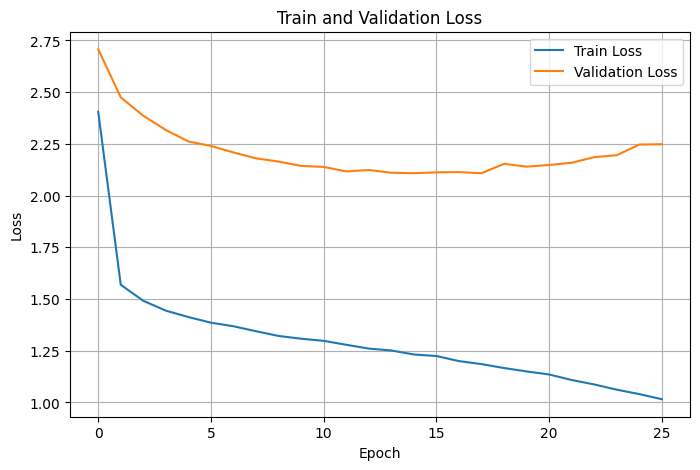

In [16]:
# your code here
# ┌(ಠ_ಠ)┘
torch.backends.cuda.matmul.allow_tf32 = True

LOAD_LAST_CHECKPOINT = True
EPOCHS = 1
EPOCH_START_NUMBER = 25

ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)
CKPT_NAME = "hw2_audio_adapter_v2.pt"
train_loss = []
val_loss = []
best_val_loss = float('inf')
best_epoch = 0

trainer = QwenAudioDescriptionTrainer(qwen_model, qwen_tokenizer, audio_encoder, audio_adapter)

# для продолжения обучения при разовых запусках
if LOAD_LAST_CHECKPOINT and os.path.exists(ckpt_dir / CKPT_NAME):
    print("Loading last checkpoint...")
    trainer.audio_adapter.load_state_dict(torch.load(ckpt_dir / CKPT_NAME))
    losses = json.load(open(ckpt_dir / "train_val_loss.json"))
    train_loss = losses["train_loss"]
    val_loss = losses["val_loss"]
    best_val_loss = min(val_loss)
    best_epoch = val_loss.index(best_val_loss)


# отдельный лоадер для лучших параметров (для NVIDIA A100)
tmp_loader = DataLoader(
    # Subset(train_dataset, range(320)),  # проверочный вариант
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn # your collate
)


if EPOCHS > 0:
    for epoch in range(EPOCH_START_NUMBER, EPOCH_START_NUMBER + EPOCHS):
        # обучаем
        train_loss.append(trainer.train_one_epoch(tmp_loader))
        # сохраняем
        ckpt_path = Path(ckpt_dir / CKPT_NAME)
        if ckpt_path.exists():
            ckpt_path.rename(ckpt_path.with_suffix(f".e{epoch-1:02d}.pt"))
        torch.save(trainer.audio_adapter.state_dict(), ckpt_dir / CKPT_NAME)
        # валидируем
        val = trainer.validate(val_loader)
        val_loss.append(val)
        # сохраняем лоссы
        with open(ckpt_dir / "train_val_loss.json", "w") as f:
            json.dump({"train_loss": train_loss, "val_loss": val_loss}, f)
        if val < best_val_loss:
            best_val_loss = val
            best_epoch = epoch
        print(f"Epoch {epoch+1}/{EPOCH_START_NUMBER + EPOCHS}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Best Val Loss: {best_val_loss:.4f}, Best Epoch: {best_epoch}")

    # для накопления массива лоссов при разовых запусках
    with open(ckpt_dir / "train_val_loss.json", "w") as f:
        json.dump({"train_loss": train_loss, "val_loss": val_loss}, f)

plot_losses(train_loss, val_loss)


In [803]:
# Пример генерации
gen_loader = DataLoader(
    Subset(train_dataset, range(160)),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn # your collate
)
it = iter(gen_loader)
trainer.generate(next(it)[0])

['1st person speakingI am a student, 2nd person speaking, 3rd person speaking, 4th person speaking, 5th person speaking, 6th person speaking, 7th person speaking, 8th person speaking, 9th person speaking, 10th person speaking',
 '##############################################################',
 '2222222222222222222222222222222222222222222222222222222222222222',
 'And then you hear the audio again. 2nd time. 3rd time. 4th time. 5th time. 6th time. 7th time. 8th time. 9th time. 10th time. 11th time. 12',
 '2You are listening to a car engine idling and a man is speaking in the background. The car engine idles and a man is speaking in the background. The car engine idles and a man is speaking in the background. The car engine idles and a man is speaking in the background. The car',
 '2222222222222222222222222222222222222222222222222222222222222222',
 'I am in the background, and I am in the foreground, and I am in the middle, and I am in the middle, and I am in the middle, and I am in the 

> Убедиться, что:
>
> При обучении лосс падает.
>
> При валидации всё аналогично, только без backward.
>
>  При генерации появляется текст (возможно, не самый качественный - это зависит от данных и количества эпох).

## Задание 4. Валидация (2 балла)

1. Используйте валидационный набор данных, чтобы проверить, насколько хорошо модель генерирует текстовые описания для аудио/картинок.

2. Реализуйте процесс генерации текстов для всех аудио/картинок из валидационного набора.

3. Используйте метрику **BERTScore** для оценки качества сгенерированных описаний.

4. Отобразите примеры сгенерированных текстов и сравните их с истинными описаниями (references).

In [ ]:
# your code here (＠_＠)
val_loader_big = DataLoader(
    # Subset(train_dataset, range(320)),  # проверочный вариант
    val_dataset,
    batch_size=64,  # 64 для NVIDIA A100
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn # your collate
)

EVAL_EPOCH_START = 0
EVAL_EPOCH_END = 25
ckpt_path = Path(ckpt_dir / CKPT_NAME)
all_predictions = []  # список списков сгенерированных текстов
all_references = []  # список списков истинных текстов
all_scores = []  # список словарей с метриками для каждой эпохи

print(f"Оценка всех сохраненных чекпоинтов: от {EVAL_EPOCH_START} до {EVAL_EPOCH_END}")
for epoch in range(EVAL_EPOCH_START, EVAL_EPOCH_END):
    ckpt_path_val = ckpt_path.with_suffix(f".e{epoch:02d}.pt")
    if ckpt_path_val.exists():
        print(f"Checkpoint {epoch}/{EVAL_EPOCH_END-1}")
        trainer.audio_adapter.load_state_dict(torch.load(ckpt_path_val))
        predictions, references, P, R, F1 = trainer.evaluate_model(val_loader_big)
        print(f"Epoch {epoch+1}/{EPOCH_START_NUMBER + EPOCHS}, BERTScore - Precision: {P.mean():.3f}, Recall: {R.mean():.3f}, F1: {F1.mean():.3f}")
        all_predictions.append(predictions)
        all_references.append(references)
        all_scores.append({"P": P.mean().item(), "R": R.mean().item(), "F1": F1.mean().item()})

all_scores_df = pd.DataFrame(all_scores)

# вывод удален, т.к. не имеет большой ценности и занимает много места

### Метрики для всех эпох обучения

In [31]:
all_scores_df

,P,R,F1
0,0.270897,0.314641,0.290029
1,0.385436,0.460461,0.418219
2,0.396182,0.460797,0.424733
3,0.379776,0.431967,0.402103
4,0.343291,0.402821,0.368768
5,0.339093,0.401511,0.364922
6,0.239216,0.328591,0.272488
7,0.235492,0.328798,0.269595
8,0.260613,0.346690,0.292591
9,0.254679,0.341005,0.286948


### Примеры генерации

In [798]:
import re

i = 17
print(f"Checkpoint {i}:")
for j in random.sample(range(len(all_predictions[i])), 10):
    if not re.search(r'[A-Za-zА-Яа-я]', all_predictions[i][j]):
        continue  # пропускаем примеры, где нет буквенных символов
    print(f"Example {j+1}:")
    print(f"Reference: {all_references[i][j]}")
    print(f"Generated: {all_predictions[i][j]}")


Checkpoint 17:
Example 23:
Reference: Water flows and trickles
Generated: 1I need to know the audio: 2. I need to know the audio: 3. I need to know the audio: 4. I need to know the audio: 5. I need to know the audio: 6. I need to know the audio: 7. I need
Example 277:
Reference: People talk quietly in the distance, followed by a police car siren wailing
Generated: 2 people are talking, a vehicle is moving, and a person is speakingThe vehicle is moving, and a person is speaking. The vehicle is moving, and a person is speaking. The vehicle is moving, and a person is speaking. The vehicle is moving, and a person is speaking. The vehicle is moving
Example 267:
Reference: A motor runs in the distance as a soft wind periodically gusts
Generated: 2You can hear the sound of a car engine idling and the wind blowing. The wind is blowing and the car engine is idling. The wind is blowing and the car engine is idling. The wind is blowing and the car engine is idling. The wind is blowing and the car

## Выводы

На основе метрик от BERTScore из `all_scores_df` можно сделать следующие выводы:

- Модель в целом научилась распознавать и описывать аудио.
- Определяются различные аудио-паттерны, особенно хорошо:
  - Голоса людей (speaking, talking)
  - Звуки животных (лай собак, чириканье птиц)
  - Природные звуки (свист ветра, журчание воды)
  - Механические звуки (работа двигателей, сирены)
- Странно, что лучшие результаты по метрикам достигнуты на эпохах 1-2 (F1 ~0.42, Precision ~0.39, Recall ~0.46)
  - На ранних эпохах часто генерировалось одно и тоже для разных примеров, хотя это был связный текст. 
  - На более поздних - появилось много "шума" вида "000000000000000000000" и т.п. (одни цифры). Но если появлялся текст, то он чаще соответствал аудио.
- Метрики стабилизировались на уровне F1 ~0.27-0.33, что указывает на необходимость дальнейшей оптимизации.
- Модель склонна к повторениям в генерируемых текстах, что снижает качество описаний.

В целом, модель демонстрирует прогресс в обучении и способность к базовому распознаванию аудио-паттернов, однако требует дальнейшей доработки для улучшения качества и точности генерируемых описаний.
